In [1]:
#import the necessary modules 
%matplotlib inline 
import numpy as np 
import matplotlib.pylab as plt 
import pandas as pd 
import scipy
import sklearn
import itertools 
from itertools import cycle 
import os.path as op
import timeit 
import json
import math

# These imports are for creating the percent occupancy heat map 
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
import multiprocessing as m_proc
m_proc.cpu_count()

4

In [3]:
# Import MDAnalysis
import MDAnalysis as mda
import statsmodels as stats
from MDAnalysis.analysis import polymer, distances, rdf

### Calculate radius of gyration and persistence length of PLGA/water simulations

In [4]:
def seg_org(poly_atoms, n_monomers):
    
    pmecl = []
    count = 0
    for i in range(n_monomers):
        fgrp = []
        count += 1
        n_atm = len(poly_atoms.select_atoms("resid "+str(count)))
        
        if count == 1:
            #print(poly_atoms.select_atoms("resid "+str(count)+" and name O13"))
            pmecl.append(poly_atoms.select_atoms("resid "+str(count)+" and (name O13 O9)"))
            #print(pmecl)
        elif count == 2:
            #print(poly_atoms.select_atoms("name O5 and resid "+str(count)))
            pmecl.append(poly_atoms.select_atoms("(resid "+str(count)+" and name O5) or (resid "+str(count-1)+" and name O9)"))
        
        if count != 2 and count != 1:
            if count == n_monomers:
                pmecl.append(poly_atoms.select_atoms("(resid "+str(count)+" and name O1) or (resid "+str(count-1)+" and name O5)"))
            elif count != n_monomers:
            #print(count)
                pmecl.append(poly_atoms.select_atoms("(resid "+str(count)+" and name O5) or (resid "+str(count-1)+" and name O5)"))

    return pmecl

In [5]:
# write function to average across frames to give ensembled averaged correlation values at each nl value
# write function to average across frames to give ensembled averaged correlation values at each nl value

def pers_length(polymer_atoms, n_monomers):
    
    vec_poly = np.zeros(shape=(3,n_monomers-1), dtype=float)
    
    len_vec = np.arange(n_monomers-1)
    
    len_vec += 1

    vec_poly[1,:] = len_vec

    count = 0 
    
    sv_ply = np.zeros(shape=(n_monomers-1), dtype=object)
    
    for i in range(n_monomers):
        
        count += 1
        
        ds_cor = np.zeros(shape=(n_monomers-count))
        
        for j in range(n_monomers - count):
        
            jh = np.arange(n_monomers - count)
            
            jh += count+1

            n6_mon1 = polymer_atoms.select_atoms("resid "+str(count))

            n6_mon2 = polymer_atoms.select_atoms("resid "+str(jh[j]))

            if j == 0: 
                    
                v1 = n6_mon1.center_of_mass() - n6_mon2.center_of_mass()
                    
                v1_norm = v1/(np.linalg.norm(v1))
            
                ds_cor[j] = v1_norm.dot(v1_norm)

            elif j != 0:
                    
                v2 = n6_mon1.center_of_mass() - n6_mon2.center_of_mass()
                    
                v2_norm = v2/(np.linalg.norm(v2))
                
                ds_cor[j] = np.dot(v1_norm, v2_norm)

            sv_ply[i] = ds_cor
    
    cor_avg = []
 
    for j in range(n_monomers-1):
        lss = []
        for i in sv_ply.flat:
            try:
                lss.append(i[j])
            except IndexError:
                pass
        cor_avg.append(np.mean(lss))
    
    nm = np.array(cor_avg)

    ang_vg = []
    for i in nm.flat:
        if i >= float(0.99):
            ang_vg.append(0)
        elif i <= float(0.99):
            ang_vg.append(math.degrees(math.acos(i)))

    vec_poly[0,:] = nm 
    vec_poly[2,:] = np.array(ang_vg)
    
    return vec_poly

In [6]:
def get_rg_pers_poly(polymer_atoms, universe, start, end, ln_bnd):
    """This function will calculate the average radius of gyration and persistence length of a polymer within a 
    trajectory block."""
    
    n_monomers = len(np.unique(polymer_atoms.resids))
    
    rg_ens = np.zeros(shape=(1,end-start))
    
    corr_v = np.zeros(shape=(n_monomers-1,end-start))
    
    #ln_corr = np.zeros(shape=(n_monomers-1, end-start))
    
    angle_v = np.zeros(shape=(n_monomers-1,end-start))
    
    v_poly = np.zeros(shape=(4,n_monomers-1))
    
    count_rg = 0
    
    universe.trajectory[start]
    
    for ts in universe.trajectory[start:end]:
        
        p_mat = pers_length(polymer_atoms, n_monomers)
        
        #print(p_mat[0])
     
        corr_v[:,count_rg] = p_mat[0]
        
        #ln_corr[:,count_rg] = np.log(p_mat[0,:])
        
        angle_v[:,count_rg] = p_mat[2]
        
        rg_ens[0,count_rg] = polymer_atoms.radius_of_gyration()
        
        count_rg += 1 
        
        universe.trajectory[end]
    #Added the calculation of the std dev for the correlation values 
    v_poly[3,:] = p_mat[1]
    
    for i in range(n_monomers-1):
        
        v_poly[0,i] = np.mean(corr_v[i,:])
        
        #Added the calculation of the std dev for the correlation values
        v_poly[1,i] = np.std(corr_v[i,:])
        
        #v_poly[2,i] = np.mean(ln_corr[i,:])
        
        #v_poly[3,i] = np.std(ln_corr[i,:])
        
        v_poly[2,i] = np.mean(angle_v[i,:])
     
    avg_rg = np.mean(rg_ens)
    
    #def expfunc(x, a):
    #    return np.exp(-x*ln_bnd/2*a)
    # Starting with x = 0 for fits
    #tr_n6 = np.arange(n_monomers-1)
    
    #tr_n6 += 1

    #pers_lp = scipy.optimize.curve_fit(expfunc, tr_n6, v_poly[0,:])[0][0]
    
    return  rg_ens, v_poly, avg_rg 

In [7]:
# I want a list of total fraction of contacts where length is determined by no. of blocks and a dictionary 
# of contact groups as keys and list of fractional contacts as values(length of list will be no. of blocks)
def bavg_pers_cnt(no_of_blks, polymer_atoms, universe, len_bnd, begin, final):
 
    n_size = (final - begin)/no_of_blks
    
    ot_dab = {}
    universe.trajectory[begin]
    
    sf_lbl = ["Avg Radius of gyration", "Avg persistence length"]

    blk_nparr = np.zeros(shape=(len(sf_lbl),no_of_blks))
    
    count = 0 
    
    for i in range(no_of_blks):
        
        start = universe.trajectory.frame
        print(start)
    
        end = int(start + n_size)
        print(end)
       
        pp_rgens, cor_pp, per_pp, rg_avgpp = get_rg_pers_poly(polymer_atoms, universe, start, end, len_bnd)
        
        blk_nparr[0,count] = rg_avgpp
        
        blk_nparr[1,count] = per_pp        
        
        universe.trajectory[end]
        
        count += 1
    # Save fractional contacts for each AA group type, each element in the value array corresponds to a block 
    # calculated value
    for i in range(len(sf_lbl)):
        ot_dab[sf_lbl[i]] = blk_nparr[i,:]
    
    return ot_dab
        

### Water only systems

## N = 6 water

In [8]:
# For the right Rg calculation using MD Analysis, use trajactory without pbc 
n6_plga_wat = mda.Universe("n6_plga_50ns/0_xa_soln/confout.gro", "n6_plga_50ns/0_xa_soln/nopbc_n6wat.xtc")

In [9]:
len(n6_plga_wat.trajectory)

5001

In [10]:
#Select the polymer heavy atoms 
poly_n6 = n6_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [11]:
com_bond = np.zeros(shape=(1,5000))
count = 0
for ts in n6_plga_wat.trajectory[0:5000]:
    n6_mon1 = n6_plga_wat.select_atoms("resid 1")
    n6_mon2 = n6_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n6_mon1.center_of_mass(), n6_mon2.center_of_mass(), 
                                                   box=n6_plga_wat.trajectory.ts.dimensions)
    com_bond[0, count] = oo_len
    count += 1
    

In [12]:
com_bond

array([[5.41774043, 4.78879205, 5.54438067, ..., 6.56805096, 6.42530086,
        6.30959793]])

In [13]:
lb_avg = np.mean(com_bond)
lb_avg

5.691897446005937

In [14]:
np.std(com_bond)

0.7661117243666821

In [ ]:
plt.scatter(np.arange(5000),com_bond)
#plt.scatter(np.arange(5000),lbond,c="y")

In [ ]:
lb_avg

In [ ]:
n6_blks = bavg_pers_cnt(5, poly_n6, n6_plga_wat, lb_avg, 0 , 5000)

In [ ]:
# Fully extended length of 6 monomer PLGA is 3.838 nm 
n6_blks["Avg persistence length"]

In [ ]:
n6_blks["Avg Radius of gyration"]

In [ ]:
np.mean(n6_blks["Avg persistence length"])

In [ ]:
np.std(n6_blks["Avg persistence length"])

In [15]:
n6_rgens, cor_n6, rg_avgn6 = get_rg_pers_poly(poly_n6, n6_plga_wat, 0, 5000, lb_avg)

In [16]:
cor_n6

array([[1.00000000e+00, 7.52881933e-01, 4.91285939e-01, 3.78040143e-01,
        3.22664698e-01],
       [6.36032808e-17, 6.58991481e-02, 1.59630817e-01, 2.84548598e-01,
        4.94750872e-01],
       [0.00000000e+00, 4.08035110e+01, 5.99560820e+01, 6.64582391e+01,
        6.84962410e+01],
       [1.00000000e+00, 2.00000000e+00, 3.00000000e+00, 4.00000000e+00,
        5.00000000e+00]])

In [17]:
cor_n6[0]

array([1.        , 0.75288193, 0.49128594, 0.37804014, 0.3226647 ])

In [18]:
cor_n6[1]

array([6.36032808e-17, 6.58991481e-02, 1.59630817e-01, 2.84548598e-01,
       4.94750872e-01])

In [19]:
mk = cor_n6[1]/cor_n6[0]
mk /= 2
mk

array([3.18016404e-17, 4.37645965e-02, 1.62462228e-01, 3.76347067e-01,
       7.66664088e-01])

In [ ]:
nt = np.arange(5)
plt.errorbar(nt, np.log(cor_n6[0]), yerr=mk, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$)', fontsize=15)
plt.xlabel('Segment Length', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)

In [ ]:
n6_corstd = cor_n6[1]/2
plt.figure(figsize=(5,5))
plt.errorbar(nt, cor_n6[0], yerr=n6_corstd, color='b', ls='--', marker='o', capsize=5, capthick=1, ecolor='black')
plt.title(r'Ensemble Averaged Cosine $\theta$', fontsize=15)
plt.xlabel('Segment Length', fontsize=15)
plt.ylabel(r'$\left< Cos(\theta)\right >$', fontsize=15)

In [20]:
# For some reason, fit does not work if lb_avg is in angstroms
lb_avg = np.mean(com_bond)
#lb_avg /= 10
lb_avg

5.691897446005937

In [21]:
# x values
nt_tt = np.arange(5, dtype=float)
nt_tt *= lb_avg/-2
nt_tt[0] = 0
nt_tt

array([  0.        ,  -2.84594872,  -5.69189745,  -8.53784617,
       -11.38379489])

In [22]:
# y values
n6lc = np.log(cor_n6[0])
n6lc

array([ 0.        , -0.28384686, -0.71072896, -0.97275489, -1.13114158])

In [ ]:
np.polyfit(n6lc, nt_tt, 0, cov=True)

In [23]:
from sklearn.linear_model import LinearRegression
model_n6 = LinearRegression(fit_intercept=False)
model_n6.fit(nt_tt.reshape(-1,1), n6lc)
# Slope here is in nanometers
print("Model slope:    ", model_n6.coef_)
print("Model intercept:", model_n6.intercept_)

Model slope:     [0.10714805]
Model intercept: 0.0


In [24]:
gg = model_n6.predict(nt_tt.reshape(-1,1))
gg

array([ 0.        , -0.30493786, -0.60987572, -0.91481358, -1.21975144])

In [25]:
mk

array([3.18016404e-17, 4.37645965e-02, 1.62462228e-01, 3.76347067e-01,
       7.66664088e-01])

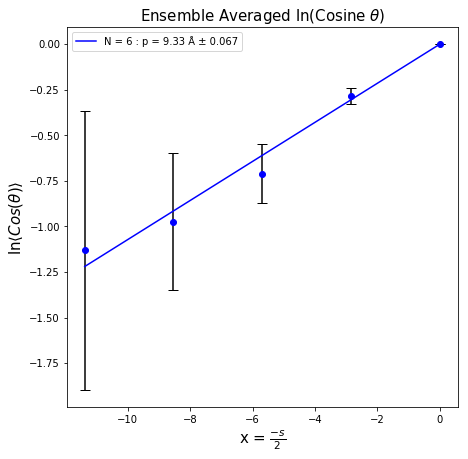

In [33]:
plt.figure(figsize=(7,7))
plt.errorbar(nt_tt, np.log(cor_n6[0]), yerr=mk, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.plot(nt_tt, gg, color='b')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$)', fontsize=15)
plt.xlabel(r'x = $\frac{-s}{2}$', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
plt.legend([r'N = 6 : p = 9.33 Å ± 0.067'])

In [29]:
print("Mean Std Error:", sklearn.metrics.mean_squared_error(np.log(cor_n6[0]), gg))
print("R2 score:", sklearn.metrics.r2_score(np.log(cor_n6[0]), gg))

Mean Std Error: 0.004365021733667115
R2 score: 0.9755140507889415


In [30]:
## Standard Error in the slope 
np.sqrt(sklearn.metrics.mean_squared_error(np.log(cor_n6[0]), gg))

0.06606831111559547

In [32]:
pers_n6 = 1/model_n6.coef_
pers_n6

array([9.3328809])

In [ ]:
lb_avg

In [ ]:
exfun(nt, pers_n6)

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg/(2*a))
nt = np.arange(5)
#nt += 1
plt.scatter(nt, cor_n6[0])
# a-axis is the number of bond lengths away 
plt.plot(nt,exfun(nt, pers_n6))
plt.ylim(0,1.2)

## N = 8 water

In [34]:
n8_plga_wat = mda.Universe("n8_plga_50ns/0_xa_soln/confout.gro", "n8_plga_50ns/0_xa_soln/nopbc_traj.xtc")

In [35]:
n8_plga_wat

<Universe with 12609 atoms>

In [36]:
#Select the polymer heavy atoms 
poly_n8 = n8_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [37]:
len(n8_plga_wat.trajectory)

5001

In [39]:
com_bond_n8 = np.zeros(shape=(1,5000))
count = 0
for ts in n8_plga_wat.trajectory[0:5000]:
    n8_mon1 = n8_plga_wat.select_atoms("resid 1")
    n8_mon2 = n8_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n8_mon1.center_of_mass(), n8_mon2.center_of_mass(), 
                                                   box=n8_plga_wat.trajectory.ts.dimensions)
    com_bond_n8[0, count] = oo_len
    count += 1
lb_avg_n8 = np.mean(com_bond_n8)
lb_avg_n8

5.419908626450464

In [ ]:
plt.scatter(np.arange(5000),com_bond_n8)
plt.scatter(np.arange(5000),com_bond)

In [ ]:
lb_avg_n8

In [ ]:
lb_avg

In [ ]:
n8_blks = bavg_pers_cnt(5, poly_n8, n8_plga_wat, lb_avg, 0 , 5000)

In [ ]:
n8_blks["Avg persistence length"]

In [ ]:
n8_blks["Avg Radius of gyration"]

In [40]:
n8_rgens, cor_n8_mat, rg_avgn8 = get_rg_pers_poly(poly_n8, n8_plga_wat, 0, 5000, lb_avg)

In [41]:
cor_n8_mat

array([[1.00000000e+00, 7.83997871e-01, 5.26026861e-01, 3.72849503e-01,
        2.77911770e-01, 2.30961802e-01, 2.70035833e-01],
       [4.12429549e-17, 4.87656382e-02, 1.14853285e-01, 1.94616388e-01,
        2.93427907e-01, 4.09681649e-01, 5.30065773e-01],
       [0.00000000e+00, 3.81441306e+01, 5.79099027e+01, 6.75021816e+01,
        7.28586935e+01, 7.52401371e+01, 7.19311438e+01],
       [1.00000000e+00, 2.00000000e+00, 3.00000000e+00, 4.00000000e+00,
        5.00000000e+00, 6.00000000e+00, 7.00000000e+00]])

In [42]:
cor_n8_mat[0]

array([1.        , 0.78399787, 0.52602686, 0.3728495 , 0.27791177,
       0.2309618 , 0.27003583])

In [43]:
cor_n8_mat[1]

array([4.12429549e-17, 4.87656382e-02, 1.14853285e-01, 1.94616388e-01,
       2.93427907e-01, 4.09681649e-01, 5.30065773e-01])

In [44]:
mk_n8 = cor_n8_mat[1]/cor_n8_mat[0]
mk_n8 /= 2
mk

array([3.18016404e-17, 4.37645965e-02, 1.62462228e-01, 3.76347067e-01,
       7.66664088e-01])

In [75]:
cor_n8_mat[1]/cor_n8_mat[0]

array([4.12429549e-17, 6.22012380e-02, 2.18341102e-01, 5.21970357e-01,
       1.05583116e+00, 1.77380695e+00, 1.96294605e+00])

In [76]:
# For some reason, fit does not work if lb_avg is in angstroms
lb_avg = np.mean(com_bond)
#lb_avg /= 10
lb_avg

5.691897446005937

In [77]:
# x values
nt_ttn8 = np.arange(7, dtype=float)
nt_ttn8 *= lb_avg/-2
nt_ttn8[0] = 0
nt_ttn8

array([  0.        ,  -2.84594872,  -5.69189745,  -8.53784617,
       -11.38379489, -14.22974362, -17.07569234])

In [78]:
# y values
n8lc = np.log(cor_n8_mat[0])
n8lc[:8]

array([ 0.        , -0.24334897, -0.642403  , -0.98658042, -1.28045159,
       -1.46550294, -1.30920061])

In [79]:
from sklearn.linear_model import LinearRegression
model_n8 = LinearRegression(fit_intercept=False)
model_n8.fit(nt_ttn8[:6].reshape(-1,1), n8lc[:6])
# Slope here is in nanometers
print("Model slope:    ", model_n8.coef_)
print("Model intercept:", model_n8.intercept_)

Model slope:     [0.10820624]
Model intercept: 0.0


In [80]:
gg_n8 = model_n8.predict(nt_ttn8.reshape(-1,1))
gg_n8

array([ 0.        , -0.30794941, -0.61589881, -0.92384822, -1.23179762,
       -1.53974703, -1.84769643])

In [81]:
pers_n8 = 1/model_n8.coef_
pers_n8

array([9.24161136])

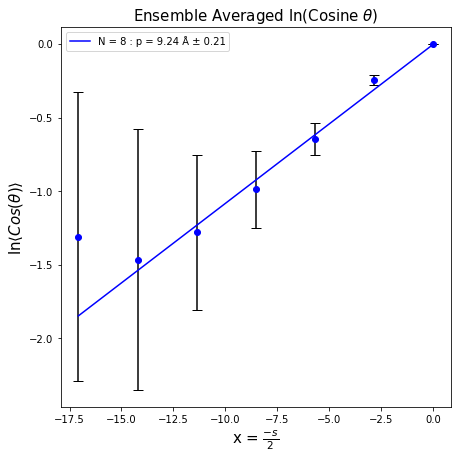

In [82]:
plt.figure(figsize=(7,7))
plt.errorbar(nt_ttn8, np.log(cor_n8_mat[0]), yerr=mk_n8, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.plot(nt_ttn8, gg_n8, color='b')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$)', fontsize=15)
plt.xlabel(r'x = $\frac{-s}{2}$', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
plt.legend([r'N = 8 : p = 9.24 Å ± 0.21'])

In [83]:
print("Mean Std Error:", sklearn.metrics.mean_squared_error(np.log(cor_n8_mat[0]), gg_n8))
print("R2 score:", sklearn.metrics.r2_score(np.log(cor_n8_mat[0]), gg_n8))

Mean Std Error: 0.04380973658093546
R2 score: 0.8408738442157477


In [84]:
## Standard Error in the slope 
np.sqrt(sklearn.metrics.mean_squared_error(np.log(cor_n8_mat[0]), gg_n8))

0.2093077556636052

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n8/a)

nt = np.arange(7)
plt.scatter(nt, cor_n8_mat[0,:])
plt.plot(nt,exfun(nt, pers_n8))

In [ ]:
np.mean(n8_blks["Avg persistence length"])

In [ ]:
np.std(n8_blks["Avg persistence length"])

## N = 10 water

In [85]:
n10_plga_wat = mda.Universe("n10_plga_50ns/0_xa_soln/N10_sys.gro", "n10_plga_50ns/0_xa_soln/nopbc_10wat.xtc")

In [86]:
n10_plga_wat

<Universe with 153 atoms>

In [87]:
len(n10_plga_wat.trajectory)

5001

In [88]:
poly_n10 = n10_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [89]:
com_bond_n10 = np.zeros(shape=(1,5000))
count = 0
for ts in n10_plga_wat.trajectory[0:5000]:
    n10_mon1 = n10_plga_wat.select_atoms("resid 1")
    n10_mon2 = n10_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n10_mon1.center_of_mass(), n10_mon2.center_of_mass(), 
                                                   box=n10_plga_wat.trajectory.ts.dimensions)
    com_bond_n10[0, count] = oo_len
    count += 1
lb_avg_n10 = np.mean(com_bond_n10)

In [90]:
lb_avg_n10

5.591477567959724

In [ ]:
plt.scatter(np.arange(5000),com_bond)
plt.scatter(np.arange(5000),com_bond_n8)
plt.scatter(np.arange(5000),com_bond_n10)

In [91]:
lb_avg

5.691897446005937

In [ ]:
n10_blks = bavg_pers_cnt(5, poly_n10, n10_plga_wat, lb_avg_n10, 0 , 5000)

In [ ]:
# Extended Length of 10 monomer length plga: 6.436 nm 
n10_blks["Avg persistence length"]

In [ ]:
n10_blks["Avg Radius of gyration"]

In [ ]:
np.mean(n10_blks["Avg Radius of gyration"])

In [ ]:
np.std(n10_blks["Avg Radius of gyration"])

In [ ]:
np.mean(n10_blks["Avg persistence length"])

In [ ]:
np.std(n10_blks["Avg persistence length"])

In [92]:
n10_rgens, cor_n10_mat, rg_avgn10 = get_rg_pers_poly(poly_n10, n10_plga_wat, 0, 1000, lb_avg)

In [93]:
cor_n10_mat

array([[1.00000000e+00, 7.69454567e-01, 5.32674496e-01, 3.71662188e-01,
        2.70039235e-01, 4.36857515e-01, 5.39196029e-01, 5.83874181e-01,
        4.32196788e-01],
       [4.60441493e-17, 3.76884003e-02, 9.32204833e-02, 1.62098542e-01,
        2.00560268e-01, 1.43741082e-01, 1.86052247e-01, 2.16977445e-01,
        3.55085311e-01],
       [0.00000000e+00, 3.95696655e+01, 5.75748243e+01, 6.77733684e+01,
        7.39199473e+01, 6.37077776e+01, 5.64830692e+01, 5.25633629e+01,
        6.13977092e+01],
       [1.00000000e+00, 2.00000000e+00, 3.00000000e+00, 4.00000000e+00,
        5.00000000e+00, 6.00000000e+00, 7.00000000e+00, 8.00000000e+00,
        9.00000000e+00]])

In [94]:
cor_n10_mat[0]

array([1.        , 0.76945457, 0.5326745 , 0.37166219, 0.27003924,
       0.43685752, 0.53919603, 0.58387418, 0.43219679])

In [95]:
cor_n10_mat[1]

array([4.60441493e-17, 3.76884003e-02, 9.32204833e-02, 1.62098542e-01,
       2.00560268e-01, 1.43741082e-01, 1.86052247e-01, 2.16977445e-01,
       3.55085311e-01])

In [104]:
mk_n10 = cor_n10_mat[1]/cor_n10_mat[0]
mk_n10 /= 2
mk_n10

array([2.30220746e-17, 2.44903350e-02, 8.75022965e-02, 2.18072416e-01,
       3.71353940e-01, 1.64517122e-01, 1.72527464e-01, 1.85808392e-01,
       4.10791242e-01])

In [97]:
cor_n10_mat[1]/cor_n10_mat[0]

array([4.60441493e-17, 4.89806701e-02, 1.75004593e-01, 4.36144831e-01,
       7.42707879e-01, 3.29034244e-01, 3.45054928e-01, 3.71616784e-01,
       8.21582485e-01])

In [98]:
# For some reason, fit does not work if lb_avg is in angstroms
lb_avg = np.mean(com_bond)
#lb_avg /= 10
lb_avg

5.691897446005937

In [99]:
# x values
nt_ttn10 = np.arange(9, dtype=float)
nt_ttn10 *= lb_avg/-2
nt_ttn10[0] = 0
nt_ttn10

array([  0.        ,  -2.84594872,  -5.69189745,  -8.53784617,
       -11.38379489, -14.22974362, -17.07569234, -19.92164106,
       -22.76758978])

In [109]:
# y values
n10lc = np.log(cor_n10_mat[0])
n10lc[:5]

array([ 0.        , -0.26207337, -0.62984474, -0.98976993, -1.30918801])

In [110]:
from sklearn.linear_model import LinearRegression
model_n10 = LinearRegression(fit_intercept=False)
model_n10.fit(nt_ttn10[:5].reshape(-1,1), n10lc[:5])
# Slope here is in nanometers
print("Model slope:    ", model_n10.coef_)
print("Model intercept:", model_n10.intercept_)

Model slope:     [0.11393769]
Model intercept: 0.0


In [120]:
gg_n10 = model_n10.predict(nt_ttn10.reshape(-1,1))
gg_n10

array([ 0.        , -0.32426082, -0.64852165, -0.97278247, -1.29704329,
       -1.62130412, -1.94556494, -2.26982577, -2.59408659])

In [121]:
pers_n10 = 1/model_n10.coef_
pers_n10

array([8.77672699])

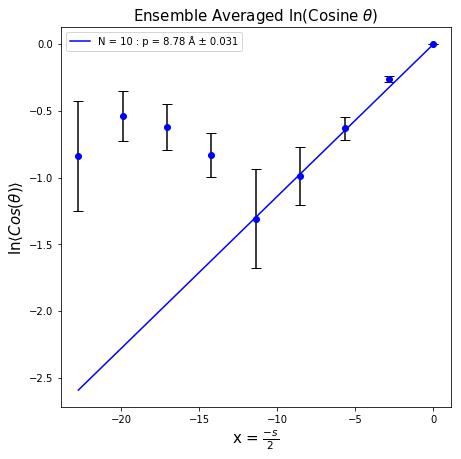

In [122]:
plt.figure(figsize=(7,7))
plt.errorbar(nt_ttn10, np.log(cor_n10_mat[0]), yerr=mk_n10, color='b', linestyle="None",marker='o',
     capsize=5, capthick=1, ecolor='black')
plt.plot(nt_ttn10, gg_n10, color='b')
plt.title(r'Ensemble Averaged ln(Cosine $\theta$)', fontsize=15)
plt.xlabel(r'x = $\frac{-s}{2}$', fontsize=15)
plt.ylabel(r'ln$\left< Cos(\theta)\right >$', fontsize=15)
plt.legend([r'N = 10 : p = 8.78 Å ± 0.031'])

In [116]:
print("Mean Std Error:", sklearn.metrics.mean_squared_error(n10lc[:5], model_n10.predict(nt_ttn10[:5].reshape(-1,1))))
print("R2 score:", sklearn.metrics.r2_score(n10lc[:5], model_n10.predict(nt_ttn10[:5].reshape(-1,1))))

Mean Std Error: 0.0009304348523263648
R2 score: 0.99585613915127


In [117]:
## Standard Error in the slope 
np.sqrt(sklearn.metrics.mean_squared_error(n10lc[:5], model_n10.predict(nt_ttn10[:5].reshape(-1,1))))

0.030503030215478014

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg/a)

nt = np.arange(9)
plt.scatter(nt, cor_n10_mat[0,:])
plt.plot(nt,exfun(nt, pers_n10))

## N = 20 water 

In [123]:
n20_plga_wat = mda.Universe("n20_plga_150ns/0_xa_soln/nowat_n20.gro", "n20_plga_150ns/0_xa_soln/N20_nopbcpp.xtc")

In [124]:
n20_plga_wat

<Universe with 303 atoms>

In [125]:
len(n20_plga_wat.trajectory)

15001

In [126]:
poly_n20 = n20_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [127]:
com_bond_n20 = np.zeros(shape=(1,15000))
count = 0
for ts in n20_plga_wat.trajectory[0:15000]:
    n20_mon1 = n20_plga_wat.select_atoms("resid 1")
    n20_mon2 = n20_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n20_mon1.center_of_mass(), n20_mon2.center_of_mass(), 
                                                   box=n20_plga_wat.trajectory.ts.dimensions)
    com_bond_n20[0, count] = oo_len
    count += 1
lb_avg_n20 = np.mean(com_bond_n20)

In [128]:
lb_avg_n20

5.5775064834288015

In [ ]:
plt.scatter(np.arange(5000),com_bond)
plt.scatter(np.arange(5000),com_bond_n8)
plt.scatter(np.arange(5000),com_bond_n10)
plt.scatter(np.arange(15000),com_bond_n20)

In [ ]:
n20_blks = bavg_pers_cnt(5, poly_n20, n20_plga_wat, lb_avg, 0 , 15000)

In [ ]:
n20_blks["Avg persistence length"]

In [ ]:
n20_blks["Avg Radius of gyration"]

In [ ]:
np.mean(n20_blks["Avg Radius of gyration"])

In [ ]:
np.std(n20_blks["Avg Radius of gyration"])

In [ ]:
np.mean(n20_blks["Avg persistence length"])

In [ ]:
np.std(n20_blks["Avg persistence length"])

In [ ]:
n20_rgens, cor_n20_mat, pers_n20, rg_avgn20 = get_rg_pers_poly(poly_n20, n20_plga_wat, 0, 15000, lb_avg)

In [ ]:
cor_n20_mat

In [ ]:
cor_n20_mat[0]

In [ ]:
cor_n20_mat[1]

In [ ]:
mk_n10 = cor_n10_mat[1]/cor_n10_mat[0]
mk_n10 /= 2
mk_n10

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg/a)

nt = np.arange(19)
plt.scatter(nt, cor_n20_mat[0,:])
plt.plot(nt,exfun(nt, pers_n10))

## N= 30 water

In [ ]:
n30_plga_wat = mda.Universe("n30_plga_150ns/0_xa_soln/0xa_n30sys.gro", "n30_plga_150ns/0_xa_soln/N30_nopbcpp_0xa.xtc")

In [ ]:
n30_plga_wat

In [ ]:
len(n30_plga_wat.trajectory)

In [ ]:
poly_n30 = n30_plga_wat.select_atoms("resname sPLG PLG tPLG and not type H")

In [ ]:
com_bond_n30 = np.zeros(shape=(1,15000))
count = 0
for ts in n30_plga_wat.trajectory[0:15000]:
    n30_mon1 = n30_plga_wat.select_atoms("resid 1")
    n30_mon2 = n30_plga_wat.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n30_mon1.center_of_mass(), n30_mon2.center_of_mass(), 
                                                   box=n30_plga_wat.trajectory.ts.dimensions)
    com_bond_n30[0, count] = oo_len
    count += 1
lb_avg_n30 = np.mean(com_bond_n30)

In [ ]:
lb_avg_n30

In [ ]:
n30_blks = bavg_pers_cnt(5, poly_n30, n30_plga_wat, lb_avg, 0 , 15000)

In [ ]:
n30_blks["Avg persistence length"]

In [ ]:
n30_blks["Avg Radius of gyration"]

In [ ]:
np.mean(n30_blks["Avg persistence length"])

In [ ]:
np.std(n30_blks["Avg persistence length"])

In [ ]:
n30_rgens, cor_n30_mat, pers_n30, rg_avgn30 = get_rg_pers_poly(poly_n30, n30_plga_wat, 0, 15000, lb_avg)

In [ ]:
cor_n30_mat

In [ ]:
cor_n30_mat[0]

In [ ]:
pers_n30

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg/a)

nt = np.arange(29)
plt.scatter(nt, cor_n30_mat[0,:])
plt.plot(nt,exfun(nt, pers_n30))

### Acetone systems only

## N = 6 acetone

In [ ]:
n6_plga_ace = mda.Universe("n6_plga_50ns/1_xa_soln/confout.gro", "n6_plga_50ns/1_xa_soln/nopbc_n6ace.xtc")

In [ ]:
n6_plga_ace

In [ ]:
len(n6_plga_ace.trajectory)

In [ ]:
poly_n6_ace = n6_plga_ace.select_atoms("resname sPLG PLG tPLG and not type H")

In [ ]:
com_bond_n6ace = np.zeros(shape=(1,5000))
count = 0
for ts in n6_plga_ace.trajectory[0:5000]:
    n6_mon1 = n6_plga_ace.select_atoms("resid 1")
    n6_mon2 = n6_plga_ace.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n6_mon1.center_of_mass(), n6_mon2.center_of_mass(), 
                                                   box=n6_plga_ace.trajectory.ts.dimensions)
    com_bond_n6ace[0, count] = oo_len
    count += 1
lb_avg_n6ace = np.mean(com_bond_n6ace)

In [ ]:
lb_avg_n6ace

In [ ]:
plt.scatter(np.arange(5000),com_bond_n6ace)


In [ ]:
n6_blks_ace = bavg_pers_cnt(5, poly_n6_ace, n6_plga_ace, lb_avg_n6ace, 0 , 5000)

In [ ]:
n6_blks_ace["Avg persistence length"]

In [ ]:
n6_blks_ace["Avg Radius of gyration"]

In [ ]:
np.mean(n6_blks_ace["Avg persistence length"])

In [ ]:
np.std(n6_blks_ace["Avg persistence length"])

In [ ]:
np.mean(n6_blks_ace["Avg Radius of gyration"])

In [ ]:
np.std(n6_blks_ace["Avg Radius of gyration"])

In [ ]:
n6_rgens_ace, cor_n6ace_mat, pers_n6ace, rg_avgnace = get_rg_pers_poly(poly_n6_ace, n6_plga_ace, 0, 5000, lb_avg_n6ace)

In [ ]:
cor_n6ace_mat

In [ ]:
cor_n6ace_mat[0]

In [ ]:
pers_n6ace

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n6ace/a)

nt = np.arange(5)
plt.scatter(nt, cor_n6ace_mat[0,:])
plt.plot(nt,exfun(nt, pers_n6ace))

## N = 8 acetone

In [ ]:
n8_plga_ace = mda.Universe("n8_plga_50ns/1_xa_soln/confout.gro", "n8_plga_50ns/1_xa_soln/nopbc_n8ace.xtc")

In [ ]:
n8_plga_ace

In [ ]:
len(n8_plga_ace.trajectory)

In [ ]:
poly_n8_ace = n8_plga_ace.select_atoms("resname sPLG PLG tPLG and not type H")

In [ ]:
com_bond_n8ace = np.zeros(shape=(1,5000))
count = 0
for ts in n8_plga_ace.trajectory[0:5000]:
    n8_mon1 = n8_plga_ace.select_atoms("resid 1")
    n8_mon2 = n8_plga_ace.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n8_mon1.center_of_mass(), n8_mon2.center_of_mass(), 
                                                   box=n8_plga_ace.trajectory.ts.dimensions)
    com_bond_n8ace[0, count] = oo_len
    count += 1
lb_avg_n8ace = np.mean(com_bond_n8ace)

In [ ]:
lb_avg_n8ace

In [ ]:
plt.scatter(np.arange(5000),com_bond_n6ace)
plt.scatter(np.arange(5000),com_bond_n8ace)

In [ ]:
n8_blks_ace = bavg_pers_cnt(5, poly_n8_ace, n8_plga_ace, lb_avg_n6ace, 0 , 5000)

In [ ]:
n8_blks_ace["Avg persistence length"]

In [ ]:
n8_blks_ace["Avg Radius of gyration"]

In [ ]:
np.mean(n8_blks_ace["Avg persistence length"])

In [ ]:
np.std(n8_blks_ace["Avg persistence length"])

In [ ]:
np.mean(n8_blks_ace["Avg Radius of gyration"])

In [ ]:
np.std(n8_blks_ace["Avg Radius of gyration"])

In [ ]:
n8_rgens_ace, cor_n8ace_mat, pers_n8ace, rg_avgn8ace = get_rg_pers_poly(poly_n8_ace, n8_plga_ace, 0, 5000, 
                                                                        lb_avg_n6ace)

In [ ]:
cor_n8ace_mat

In [ ]:
cor_n8ace_mat[0]

In [ ]:
pers_n8ace

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n6ace/a)

nt = np.arange(7)
plt.scatter(nt, cor_n8ace_mat[0,:])
plt.plot(nt,exfun(nt, pers_n8ace))

## N = 10 acetone

In [ ]:
n10_plga_ace = mda.Universe("n10_plga_50ns/1_xa_soln/confout.gro", "n10_plga_50ns/1_xa_soln/nopbc_n10ace.xtc")

In [ ]:
n10_plga_ace

In [ ]:
len(n10_plga_ace.trajectory)

In [ ]:
poly_n10_ace = n10_plga_ace.select_atoms("resname sPLG PLG tPLG and not type H")

In [ ]:
com_bond_n10ace = np.zeros(shape=(1,5000))
count = 0
for ts in n10_plga_ace.trajectory[0:5000]:
    n10_mon1 = n10_plga_ace.select_atoms("resid 1")
    n10_mon2 = n10_plga_ace.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n10_mon1.center_of_mass(), n10_mon2.center_of_mass(), 
                                                   box=n10_plga_ace.trajectory.ts.dimensions)
    com_bond_n10ace[0, count] = oo_len
    count += 1
lb_avg_n10ace = np.mean(com_bond_n10ace)

In [ ]:
lb_avg_n10ace

In [ ]:
plt.scatter(np.arange(5000),com_bond_n6ace)
plt.scatter(np.arange(5000),com_bond_n8ace)
plt.scatter(np.arange(5000),com_bond_n10ace)

In [ ]:
n10_blks_ace = bavg_pers_cnt(5, poly_n10_ace, n10_plga_ace, lb_avg_n10ace, 0 , 5000)

In [ ]:
n10_blks_ace["Avg persistence length"]

In [ ]:
n10_blks_ace["Avg Radius of gyration"]

In [ ]:
np.mean(n10_blks_ace["Avg persistence length"])

In [ ]:
np.std(n10_blks_ace["Avg persistence length"])

In [ ]:
np.mean(n10_blks_ace["Avg Radius of gyration"])

In [ ]:
np.std(n10_blks_ace["Avg Radius of gyration"])

In [ ]:
n10_rgens_ace, cor_n10ace_mat, pers_n10ace, rg_avgn10ace = get_rg_pers_poly(poly_n10_ace, n10_plga_ace, 0, 5000, 
                                                                        lb_avg_n6ace)

In [ ]:
cor_n10ace_mat

In [ ]:
cor_n10ace_mat[0]

In [ ]:
pers_n10ace

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n6ace/a)

nt = np.arange(9)
plt.scatter(nt, cor_n10ace_mat[0,:])
plt.plot(nt,exfun(nt, pers_n10ace))

## N = 20 acetone

In [ ]:
n20_plga_ace = mda.Universe("n20_plga_150ns/1_xa_soln/1xa_n20sys.gro", "n20_plga_150ns/1_xa_soln/N20_nopbcpp_0xa.xtc")

In [ ]:
n20_plga_ace

In [ ]:
len(n20_plga_ace.trajectory)

In [ ]:
poly_n20_ace = n20_plga_ace.select_atoms("resname sPLG PLG tPLG and not type H")

In [ ]:
com_bond_n20ace = np.zeros(shape=(1,5000))
count = 0
for ts in n20_plga_ace.trajectory[0:5000]:
    n20_mon1 = n20_plga_ace.select_atoms("resid 1")
    n20_mon2 = n20_plga_ace.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n20_mon1.center_of_mass(), n20_mon2.center_of_mass(), 
                                                   box=n20_plga_ace.trajectory.ts.dimensions)
    com_bond_n20ace[0, count] = oo_len
    count += 1
lb_avg_n20ace = np.mean(com_bond_n20ace)

In [ ]:
lb_avg_n20ace

In [ ]:
plt.scatter(np.arange(5000),com_bond_n6ace)
plt.scatter(np.arange(5000),com_bond_n8ace)
plt.scatter(np.arange(5000),com_bond_n10ace)
plt.scatter(np.arange(5000),com_bond_n20ace)

In [ ]:
n20_blks_ace = bavg_pers_cnt(5, poly_n20_ace, n20_plga_ace, lb_avg_n6ace, 0 , 15000)

In [ ]:
n20_blks_ace["Avg persistence length"]

In [ ]:
n20_blks_ace["Avg Radius of gyration"]

In [ ]:
np.mean(n20_blks_ace["Avg persistence length"])

In [ ]:
np.std(n20_blks_ace["Avg persistence length"])

In [ ]:
np.mean(n20_blks_ace["Avg Radius of gyration"])

In [ ]:
np.std(n20_blks_ace["Avg Radius of gyration"])

In [ ]:
n20_rgens_ace, cor_n20ace_mat, pers_n20ace, rg_avgn20ace = get_rg_pers_poly(poly_n20_ace, n20_plga_ace, 0, 15000, 
                                                                        lb_avg_n6ace)

In [ ]:
cor_n20ace_mat

In [ ]:
cor_n20ace_mat[0]

In [ ]:
pers_n20ace

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n6ace/a)

nt = np.arange(19)
plt.scatter(nt, cor_n20ace_mat[0,:])
plt.plot(nt,exfun(nt, pers_n20ace))

## N = 30 acetone

In [ ]:
n30_plga_ace = mda.Universe("n30_plga_150ns/1_xa_soln/1xa_n30sys.gro", "n30_plga_150ns/1_xa_soln/N30_nopbcpp_1xa.xtc")

In [ ]:
n30_plga_ace

In [ ]:
len(n30_plga_ace.trajectory)

In [ ]:
poly_n30_ace = n30_plga_ace.select_atoms("resname sPLG PLG tPLG and not type H")

In [ ]:
com_bond_n30ace = np.zeros(shape=(1,5000))
count = 0
for ts in n30_plga_ace.trajectory[0:5000]:
    n30_mon1 = n30_plga_ace.select_atoms("resid 1")
    n30_mon2 = n30_plga_ace.select_atoms("resid 2")
    oo_len = mda.analysis.distances.distance_array(n30_mon1.center_of_mass(), n30_mon2.center_of_mass(), 
                                                   box=n30_plga_ace.trajectory.ts.dimensions)
    com_bond_n30ace[0, count] = oo_len
    count += 1
lb_avg_n30ace = np.mean(com_bond_n30ace)

In [ ]:
lb_avg_n30ace

In [ ]:
plt.scatter(np.arange(5000),com_bond_n6ace)
plt.scatter(np.arange(5000),com_bond_n8ace)
plt.scatter(np.arange(5000),com_bond_n10ace)
plt.scatter(np.arange(5000),com_bond_n20ace)
plt.scatter(np.arange(5000),com_bond_n30ace)

In [ ]:
n30_blks_ace = bavg_pers_cnt(5, poly_n30_ace, n30_plga_ace, lb_avg_n6ace, 0 , 15000)

In [ ]:
n30_blks_ace["Avg persistence length"]

In [ ]:
n30_blks_ace["Avg Radius of gyration"]

In [ ]:
np.mean(n30_blks_ace["Avg persistence length"])

In [ ]:
np.std(n30_blks_ace["Avg persistence length"])

In [ ]:
np.mean(n30_blks_ace["Avg Radius of gyration"])

In [ ]:
np.std(n30_blks_ace["Avg Radius of gyration"])

In [ ]:
n30_rgens_ace, cor_n30ace_mat, pers_n30ace, rg_avgn30ace = get_rg_pers_poly(poly_n30_ace, n30_plga_ace, 0, 15000, 
                                                                        lb_avg_n6ace)

In [ ]:
cor_n30ace_mat

In [ ]:
cor_n30ace_mat[0]

In [ ]:
pers_n30ace

In [ ]:
def exfun(x, a):
    return np.exp(-x*lb_avg_n6ace/a)

nt = np.arange(29)
plt.scatter(nt, cor_n30ace_mat[0,:])
plt.plot(nt,exfun(nt, pers_n30ace))